In [ ]:
#!pip install geopy


In [123]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score

## Emissions

In [116]:
df_emissions = pd.read_csv("./Data/emisssions.csv")
df_emissions.head()

,city,date,sector,value,timestamp
0,Canberra,01/01/2019,Aviation,0.026581,1546300800
1,Canberra,02/01/2019,Aviation,0.028275,1546387200
2,Canberra,03/01/2019,Aviation,0.028120,1546473600
3,Canberra,04/01/2019,Aviation,0.028199,1546560000
4,Canberra,05/01/2019,Aviation,0.028428,1546646400


In [117]:
df_emissions_clean = df_emissions[(df_emissions['city'] == "New York (Greater)") & 
                                     (df_emissions['sector'] == "Ground Transport")].copy()
df_emissions_clean['date'] = pd.to_datetime(df_emissions_clean['date'], format='%d/%m/%Y')
df_emissions_clean['year'] = df_emissions_clean['date'].dt.year

df_emissions_clean.drop(columns=['city', 'sector'], inplace=True)
df_emissions_clean.head()

,date,value,timestamp,year
247696,2019-01-01,68.3429,1546300800,2019
247697,2019-01-02,81.1451,1546387200,2019
247698,2019-01-03,84.8457,1546473600,2019
247699,2019-01-04,84.0457,1546560000,2019
247700,2019-01-05,86.4491,1546646400,2019


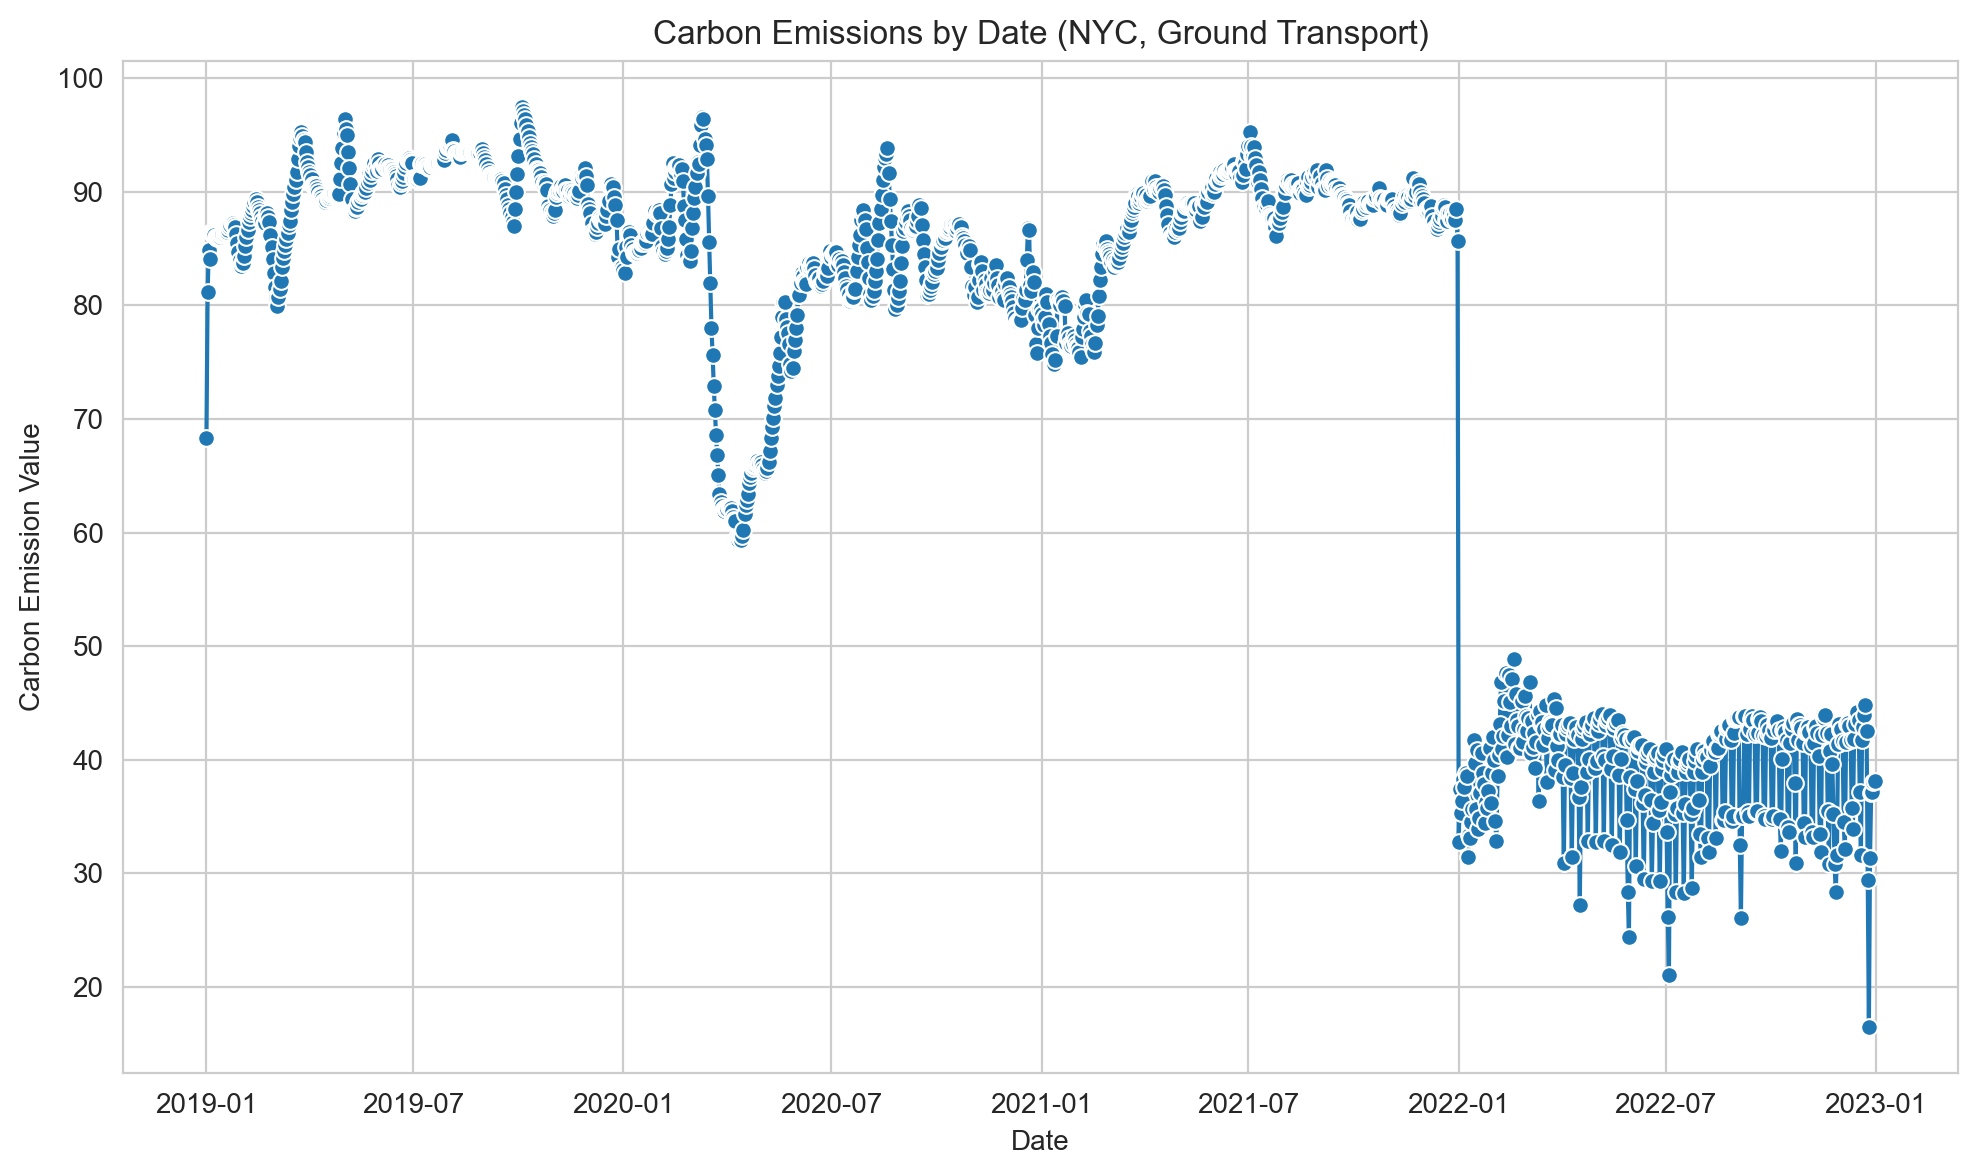

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(x='date', y='value', data=df_emissions_clean, marker='o')
plt.title('Carbon Emissions by Date (NYC, Ground Transport)')
plt.xlabel('Date')
plt.ylabel('Carbon Emission Value')
plt.xticks(rotation=45)
plt.tick_params(labelsize=10)
plt.tight_layout()
plt.show()

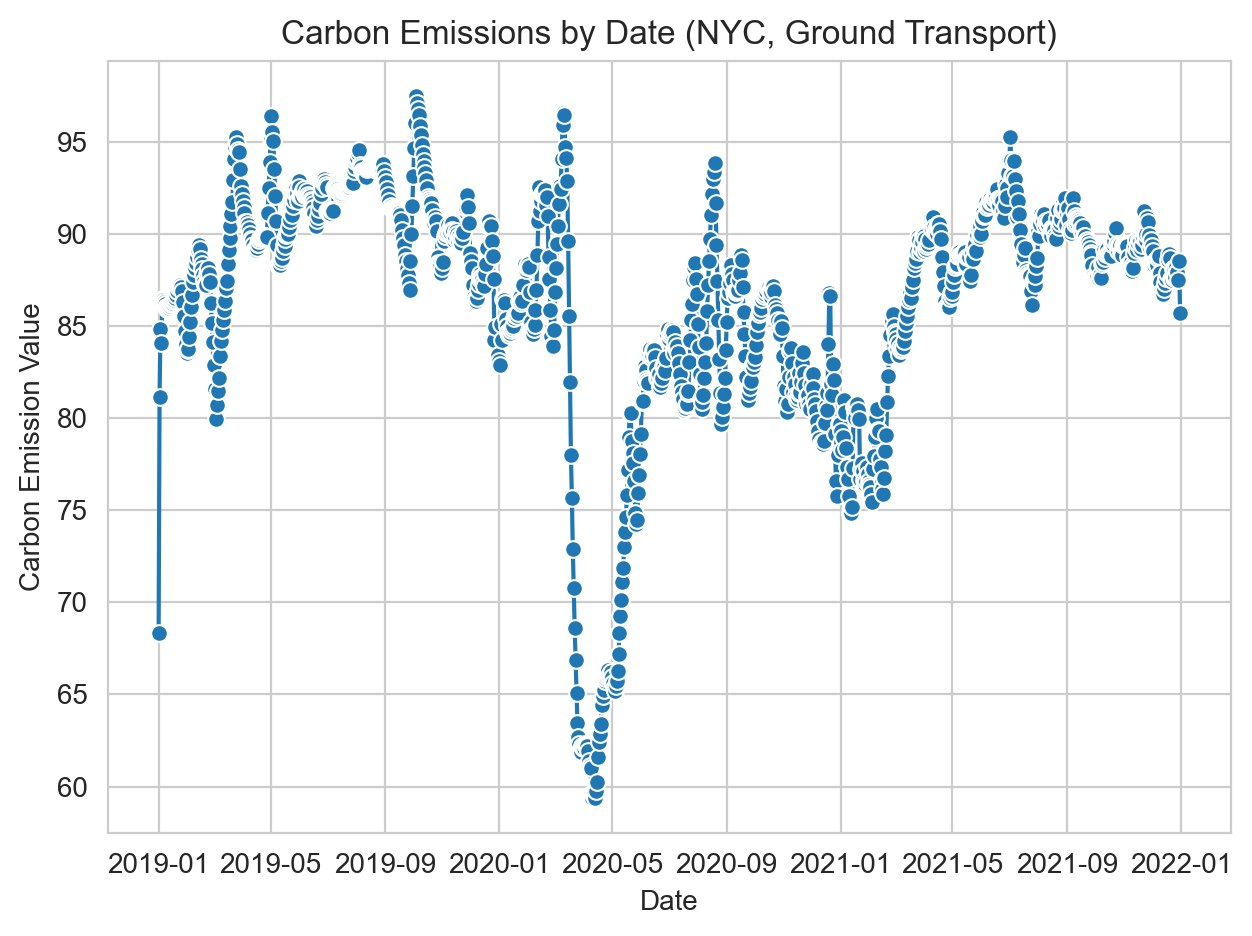

In [119]:
df_emissions_clean = df_emissions_clean[df_emissions_clean['year'] != 2022]
sns.lineplot(x='date', y='value', data=df_emissions_clean, marker='o')
plt.title('Carbon Emissions by Date (NYC, Ground Transport)')
plt.xlabel('Date')
plt.ylabel('Carbon Emission Value')
plt.tight_layout()
plt.show()

## Bikes

In [120]:
dfs = []

folder_path = './Data/CitiBike 2020/'
all_files = os.listdir(folder_path)
for file in all_files:
    file_path = os.path.join(folder_path, file)
    dfs.append(pd.read_csv(file_path))

folder_path = './Data/CitiBike 2021/'
all_files = os.listdir(folder_path)
for file in all_files:
    file_path = os.path.join(folder_path, file)
    dfs.append(pd.read_csv(file_path))

df_bike = pd.concat(dfs, ignore_index=True)
df_bike['trip minutes'] = df_bike['tripduration'] / 60
df_bike.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,trip minutes
0,146,2020-12-01 00:02:50.1450,2020-12-01 00:05:16.1940,3202,Newport PATH,40.727224,-74.033759,3199,Newport Pkwy,40.728745,-74.032108,42308,Subscriber,1989,2,2.433333
1,572,2020-12-01 00:11:57.3910,2020-12-01 00:21:30.2510,3640,Journal Square,40.733670,-74.062500,3280,Astor Place,40.719282,-74.071262,18568,Subscriber,1997,2,9.533333
2,387,2020-12-01 00:14:49.3610,2020-12-01 00:21:16.8730,3640,Journal Square,40.733670,-74.062500,3194,McGinley Square,40.725340,-74.067622,44543,Subscriber,1960,1,6.450000
3,188,2020-12-01 00:45:06.3680,2020-12-01 00:48:14.4280,3186,Grove St PATH,40.719586,-74.043117,3270,Jersey & 6th St,40.725289,-74.045572,43098,Subscriber,1998,1,3.133333
4,594,2020-12-01 01:17:17.0110,2020-12-01 01:27:11.9400,3212,Christ Hospital,40.734786,-74.050444,3209,Brunswick St,40.724176,-74.050656,44723,Subscriber,1988,1,9.900000


In [125]:
def calculate_distance(row):
    pt1 = (row['start station latitude'], row['start station longitude'])
    pt2 = (row['end station latitude'], row['end station longitude'])
    return geodesic(pt1, pt2).miles

df_bike['distance'] = df_bike.apply(calculate_distance, axis=1)
df_bike.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,trip minutes,distance
0,146,2020-12-01 00:02:50.1450,2020-12-01 00:05:16.1940,3202,Newport PATH,40.727224,-74.033759,3199,Newport Pkwy,40.728745,-74.032108,42308,Subscriber,1989,2,2.433333,0.136117
1,572,2020-12-01 00:11:57.3910,2020-12-01 00:21:30.2510,3640,Journal Square,40.733670,-74.062500,3280,Astor Place,40.719282,-74.071262,18568,Subscriber,1997,2,9.533333,1.094164
2,387,2020-12-01 00:14:49.3610,2020-12-01 00:21:16.8730,3640,Journal Square,40.733670,-74.062500,3194,McGinley Square,40.725340,-74.067622,44543,Subscriber,1960,1,6.450000,0.634572
3,188,2020-12-01 00:45:06.3680,2020-12-01 00:48:14.4280,3186,Grove St PATH,40.719586,-74.043117,3270,Jersey & 6th St,40.725289,-74.045572,43098,Subscriber,1998,1,3.133333,0.414075
4,594,2020-12-01 01:17:17.0110,2020-12-01 01:27:11.9400,3212,Christ Hospital,40.734786,-74.050444,3209,Brunswick St,40.724176,-74.050656,44723,Subscriber,1988,1,9.900000,0.732154


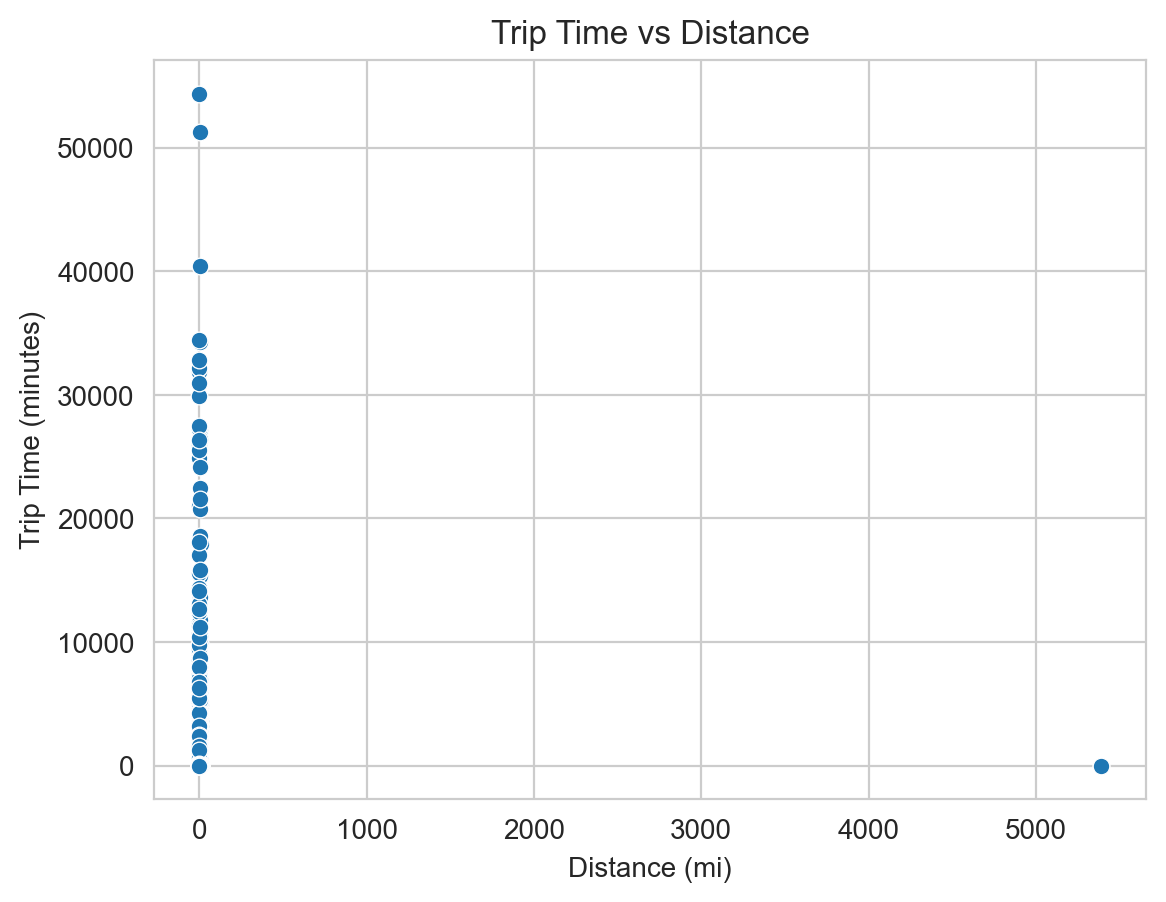

In [126]:
sns.scatterplot(x='distance', y='trip minutes', data=df_bike)
plt.xlabel('Distance (mi)')
plt.ylabel('Trip Time (minutes)')
plt.title('Trip Time vs Distance')
plt.show()

In [127]:
df_bike_clean = df_bike[(df_bike['trip minutes'] <= 15) & (df_bike['distance'] > 0)].copy()
df_bike_clean[df_bike_clean['distance'] > 200]

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,trip minutes,distance
224941,706,2020-07-17 08:49:47.8100,2020-07-17 09:01:33.8810,3186,Grove St PATH,40.719586,-74.043117,3475,Liberty State Park,0.0,0.0,40831,Subscriber,1991,1,11.766667,5387.688715
229080,546,2020-07-20 08:53:36.6680,2020-07-20 09:02:42.8980,3694,Jackson Square,40.711130,-74.078900,3475,Liberty State Park,0.0,0.0,44683,Subscriber,1997,1,9.100000,5389.431226


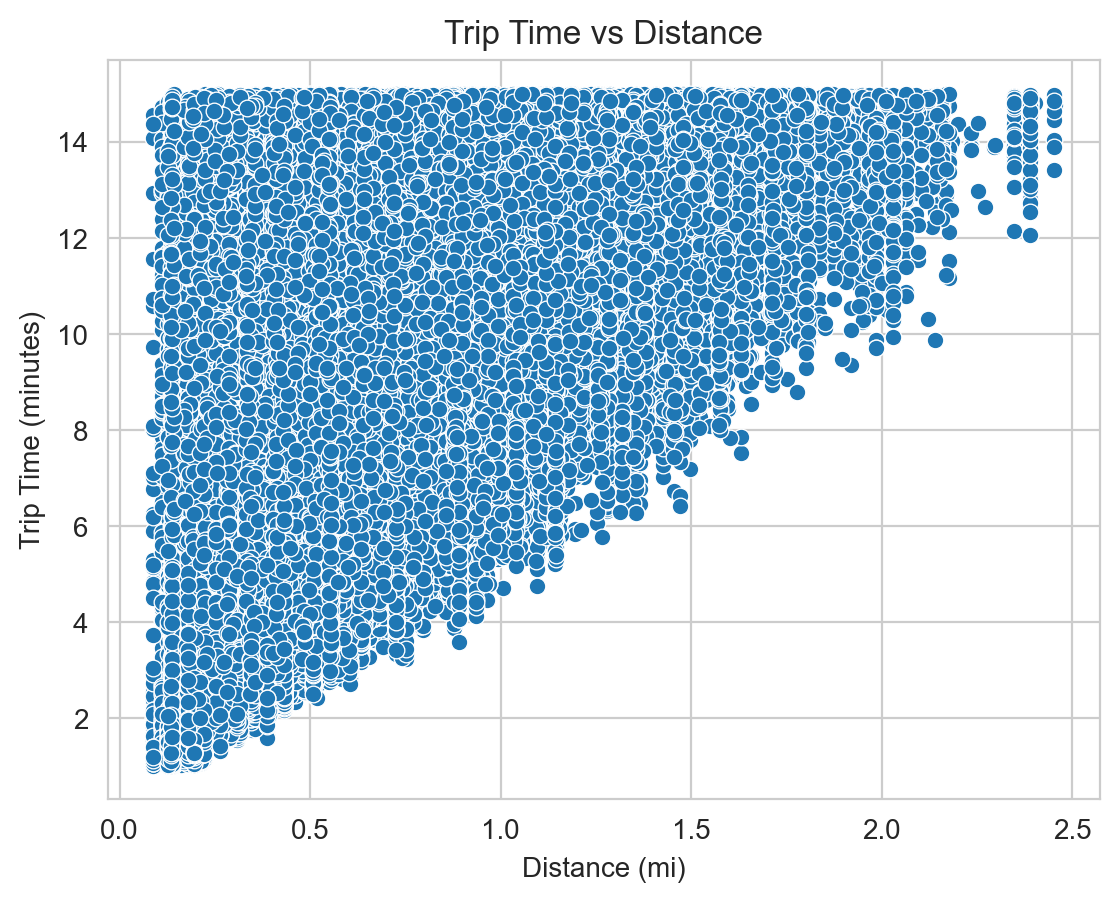

In [128]:
df_bike_clean.drop([224941, 229080], inplace=True)
sns.scatterplot(x='distance', y='trip minutes', data=df_bike_clean)
plt.xlabel('Distance (mi)')
plt.ylabel('Trip Time (minutes)')
plt.title('Trip Time vs Distance')
plt.show()

In [133]:
df_bike_clean = df_bike_clean[['starttime', 'stoptime', 'trip minutes', 'distance']].copy()

df_bike_clean['starttime'] = pd.to_datetime(df_bike_clean['starttime'])
df_bike_clean['date'] = df_bike_clean['starttime'].dt.date
df_bike_clean['time of day'] = pd.cut(df_bike_clean['starttime'].dt.hour, 
                                      bins=[0, 12, 16, 24], 
                                      labels=['Morning', 'Afternoon', 'Night'], 
                                      right=False)
df_bike_clean.head()

,starttime,stoptime,trip minutes,distance,date,time of day
0,2020-12-01 00:02:50.145,2020-12-01 00:05:16.1940,2.433333,0.136117,2020-12-01,Morning
1,2020-12-01 00:11:57.391,2020-12-01 00:21:30.2510,9.533333,1.094164,2020-12-01,Morning
2,2020-12-01 00:14:49.361,2020-12-01 00:21:16.8730,6.450000,0.634572,2020-12-01,Morning
3,2020-12-01 00:45:06.368,2020-12-01 00:48:14.4280,3.133333,0.414075,2020-12-01,Morning
4,2020-12-01 01:17:17.011,2020-12-01 01:27:11.9400,9.900000,0.732154,2020-12-01,Morning


## Weather

In [ ]:
df_weather = pd.read_csv('./Data/nyc_temperatures.csv')
df_weather.head()

In [ ]:
df_weather = df_weather.groupby('DATE').agg({
    'PRCP': 'mean',
    'SNOW': 'mean',
    'SNWD': 'mean',
    'TMAX': 'mean',
    'TMIN': 'mean'
}).reset_index()

df_weather.columns = [col.lower() for col in df_weather.columns]

df_weather['tmid'] = (df_weather['tmax'] + df_weather['tmin']) / 2
df_weather.head()

In [ ]:
df_weather['date'] = pd.to_datetime(df_weather['date']).dt.date

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='tmid', data=df_weather, marker='o')

plt.title('Temp Levels')
plt.xlabel('Date')
plt.ylabel('Temp')
plt.tight_layout()
plt.show()

## Bike Emissions

In [150]:
df_bike_clean['date'] = df_bike_clean['date'].astype('datetime64[ns]')
# merging emissions and bike on date
merge_bike_emmissions = pd.merge(df_emissions_clean, df_bike_clean, on="date")
merge_bike_emmissions.head()

,date,value,timestamp,year,starttime,stoptime,trip minutes,distance,time of day
0,2020-01-01,83.1135,1577836800,2020,2020-01-01 00:04:50.192,2020-01-01 00:08:37.0370,3.766667,0.214238,Morning
1,2020-01-01,83.1135,1577836800,2020,2020-01-01 00:16:01.670,2020-01-01 00:22:19.0800,6.283333,0.585072,Morning
2,2020-01-01,83.1135,1577836800,2020,2020-01-01 00:17:33.877,2020-01-01 00:22:22.4420,4.800000,0.585072,Morning
3,2020-01-01,83.1135,1577836800,2020,2020-01-01 00:32:05.902,2020-01-01 00:39:21.0660,7.250000,0.889481,Morning
4,2020-01-01,83.1135,1577836800,2020,2020-01-01 00:46:19.678,2020-01-01 00:50:11.3440,3.850000,0.345515,Morning


In [ ]:
ct = ColumnTransformer(
    [("cat", OneHotEncoder(), ['time of day']),
     ("num", StandardScaler(), make_column_selector(dtype_include=np.number))],
    remainder='passthrough'
)

pipeline_lr = Pipeline(
    [("preprocessor", ct),
     ("lr", LinearRegression())]
)
params_lr = {}

piprlinr_lasso = Pipeline(
    [("preprocessing", ct),
     ("lasso", Lasso())]
)
params_lasso = {
    'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

pipeline_ridge = Pipeline(
    [("preprocessing", ct),
     ("ridge", Ridge())]
)
params_ridge = {
    'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

pipeline_net = Pipeline(
    [("preprocessing", ct),
     ("net", ElasticNet())]
)
params_net = {
    'net__alpha': [0.001, 0.01, 0.1, 1],
    'net__l1_ratio': [0.2, 0.5, 0.8]
}

pipeline_forest = Pipeline(
    [("preprocessing",ct),
    ("forest", RandomForestRegressor())
])
params_forest = {
    'forest__n_estimators': [100, 200, 300],
    'forest__max_depth': [None, 10, 20, 30],
    'forest__min_samples_split': [2, 5, 10],
    'forest__min_samples_leaf': [1, 2, 4],
    'forest__max_features': ['auto', 'sqrt']
}

pipeline_xgb = Pipeline(
    [("preprocessor", ct),
     ("xgb", XGBRegressor(objective='reg:squarederror'))]
)
params_xgb = {
    'xgb__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'xgb__max_depth': [3, 4, 5, 6, 7],
    'xgb__n_estimators': [100, 200, 300],
    'xgb__subsample': [0.7, 0.8, 0.9]
}

pipelines = {
    "Linear Regression": pipeline_lr,
    "Lasso": piprlinr_lasso,
    "Ridge": pipeline_ridge,
    "Elastic Net": pipeline_net,
    "XGBoost": pipeline_xgb
}
params = {
    "Linear Regression": params_lr,
    "Lasso": params_lasso,
    "Ridge": params_ridge,
    "Elastic Net": params_net,
    "XGBoost": params_xgb
}

## Bike Weather

In [ ]:
# Merge by indivdual bike trip
df_bike_weather_ind = df_bike_clean.merge(df_weather, on='date')
print(f"rows: {len(df_bike_weather_ind)}")
df_bike_weather_ind.head()

In [ ]:
# Merge by date and time of day
df_bike_agg = df_bike_clean.groupby(['date', 'time of day']).agg({
    'trip minutes': 'sum',
    'distance': 'sum',
    'date': 'size'}).rename(columns={'date': 'ride count'}).reset_index()

df_bike_weather = df_bike_agg.merge(df_weather, on='date')
print(f"rows: {len(df_bike_weather)}")
df_bike_weather.head()

In [130]:
X = df_bike_weather[['time of day', 'prcp', 'snow', 'snwd', 'tmax', 'tmin']]
y = df_bike_weather['ride count']

X_ind = df_bike_weather_ind[['time of day', 'prcp', 'snow', 'snwd', 'tmax', 'tmin']]
y_ind = df_bike_weather_ind[['trip minutes', 'distance']]

In [135]:
ct = ColumnTransformer(
    [("cat", OneHotEncoder(), ['time of day']),
     ("num", StandardScaler(), make_column_selector(dtype_include=np.number))],
    remainder='passthrough'
)

pipeline_lr = Pipeline(
    [("preprocessor", ct),
     ("lr", LinearRegression())]
)
params_lr = {}

piprlinr_lasso = Pipeline(
    [("preprocessing", ct),
     ("lasso", Lasso())]
)
params_lasso = {
    'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

pipeline_ridge = Pipeline(
    [("preprocessing", ct),
     ("ridge", Ridge())]
)
params_ridge = {
    'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

pipeline_net = Pipeline(
    [("preprocessing", ct),
     ("net", ElasticNet())]
)
params_net = {
    'net__alpha': [0.001, 0.01, 0.1, 1],
    'net__l1_ratio': [0.2, 0.5, 0.8]
}

pipeline_forest = Pipeline(
    [("preprocessing",ct),
    ("forest", RandomForestRegressor())
])
params_forest = {
    'forest__n_estimators': [100, 200, 300],
    'forest__max_depth': [None, 10, 20, 30],
    'forest__min_samples_split': [2, 5, 10],
    'forest__min_samples_leaf': [1, 2, 4],
    'forest__max_features': ['auto', 'sqrt']
}

pipeline_xgb = Pipeline(
    [("preprocessor", ct),
     ("xgb", XGBRegressor(objective='reg:squarederror'))]
)
params_xgb = {
    'xgb__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'xgb__max_depth': [3, 4, 5, 6, 7],
    'xgb__n_estimators': [100, 200, 300],
    'xgb__subsample': [0.7, 0.8, 0.9]
}

pipelines = {
    "Linear Regression": pipeline_lr,
    "Lasso": piprlinr_lasso,
    "Ridge": pipeline_ridge,
    "Elastic Net": pipeline_net,
    "XGBoost": pipeline_xgb
}
params = {
    "Linear Regression": params_lr,
    "Lasso": params_lasso,
    "Ridge": params_ridge,
    "Elastic Net": params_net,
    "XGBoost": params_xgb
}

In [151]:
for model_name, pipeline in pipelines.items():
    print(model_name)
    grid_search = GridSearchCV(pipeline, params[model_name], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)
    
    print(f'Mean MSE for ride count: {-grid_search.best_score_}')
    
    for target in y_ind.columns:
        grid_search.fit(X_ind, y_ind[target])
        print(f'Mean MSE for {target}: {-grid_search.best_score_}')

Linear Regression
Mean MSE for ride count: 14281.844901739692
Mean MSE for trip minutes: 11.410321466541006
Mean MSE for distance: 0.11004267519364837
Lasso
Mean MSE for ride count: 14270.438460613
Mean MSE for trip minutes: 11.41056533104327
Mean MSE for distance: 0.11005250401593372
Ridge
Mean MSE for ride count: 14129.994219198188
Mean MSE for trip minutes: 11.410441731033616
Mean MSE for distance: 0.11004509835273757
Elastic Net
Mean MSE for ride count: 14134.572475452678
Mean MSE for trip minutes: 11.410439909846113
Mean MSE for distance: 0.11005178948416358
XGBoost
Mean MSE for ride count: 14765.378729401835
Mean MSE for trip minutes: 11.406622153058754
Mean MSE for distance: 0.10997363322006697
